In [2]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [13]:
def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

def boot_ci_gamma(data,identifier,test_range_param_1=None,test_range_param_2=None,num_repeat=1000,seed=42,ci=0.95):
    '''
    Summary:
    -----------
    Function which performs the bootstrapping for the gamma distribution. The data is stored in a pandas array
    to combine multiple results
    
    Parameters:
    -----------
    data: Array
            - Data to be bootstrapped
            
    identifier: str 
            - Name of the model of the Data
         
    (opt) test_range_param_1: array 
            - "None" if identifier is a observational model, if it is a CMIP6 model this array should 
            contain the mean, lower and upper value for the first parameter of the observational fitting
            to evaluate how well the CMIP6 model performs
    
    (opt) test_range_param_1: array 
            - "None" if identifier is a observational model, if it is a CMIP6 model this array should 
            contain the mean, lower and upper value for the second parameter of the observational fitting
            to evaluate how well the CMIP6 model performs
            
    (opt) num_repeat: float 
            - specifies the number of repetitions for the bootstrapping, is set per default to 1000
    
    (opt) seed: int 
            - sets the seed for the random selection, is necessary to obtain the same results when the the code
            is run multipl times, is set per default to 42
    
    (opt) ci: float 
            - sets the confidence interval to obtain the upper and lower bound of the bootstrapped data,
            is set per default to 95%
            
         
    Returns:
    ----------
    param_1: Array
            - Mean, upper and lower value of the bootstrapped data for the first fitting parameter      
        
    param_2: Array
            - Mean, upper and lower value of the bootstrapped data for the second fitting parameter   
    '''
    num_samples = len(data)
    np.random.seed(seed)
    params = np.zeros((2,num_repeat))
    alpha = 1 - ci
    #perform the bootstrapping
    for i in np.arange(0,num_repeat,1):
        data_resampled = np.random.choice(data,size=num_samples,replace=True)
        gamma = stats.gamma
        param_gamma = gamma.fit(data_resampled,floc=0)
        params[0][i] = param_gamma[0]
        params[1][i] = param_gamma[2]
        
    #Calculate the output values
    param_1_mean = np.mean(params[0])
    param_2_mean = np.mean(params[1])
    param_1_lq = np.percentile(params[0], alpha/2*100, axis=0)
    param_1_uq = np.percentile(params[0], (1-alpha/2)*100, axis=0)
    param_2_lq = np.percentile(params[1], alpha/2*100, axis=0)
    param_2_uq = np.percentile(params[1], (1-alpha/2)*100, axis=0)
    
    #Perform the evaluation if the data is from a CMIP6 model
    if test_range_param_1 is None and test_range_param_2 is None:
        fn_param_1 = "P1_" + identifier
        param_1 = pd.Series(np.array([param_1_mean,param_1_lq,param_1_uq]), name=fn_param_1)
        fn_param_2 = "P2_" + identifier
        param_2 = pd.Series(np.array([param_2_mean,param_2_lq,param_2_uq]), name=fn_param_2)
    else:
        para_1_tester=False
        para_2_tester=False
        #Param 1
        if para_1_tester==False and param_1_mean>=test_range_param_1[1] and param_1_mean<=test_range_param_1[2]:
            fit_param_1 = "Good"
            para_1_tester = True
        elif (para_1_tester==False and 
        (param_1_uq>test_range_param_1[2] and param_1_lq<test_range_param_1[2]) or 
        (param_1_lq<test_range_param_1[1] and param_1_uq>test_range_param_1[1])):
            fit_param_1 = "Reasonable"
            para_1_tester = True
        elif para_1_tester==False:
            fit_param_1 = "Bad"
        #Param 2    
        if para_2_tester==False and param_2_mean>=test_range_param_2[1] and param_2_mean<=test_range_param_2[2]:
            fit_param_2 = "Good"
            para_2_tester = True
        elif (para_2_tester==False and
        (param_2_uq>test_range_param_2[2] and param_2_lq<test_range_param_2[2]) or 
        (param_2_lq<test_range_param_2[1] and param_2_uq>test_range_param_2[1])):
            fit_param_2 = "Reasonable"
            para_2_tester = True
        elif para_2_tester==False:
            fit_param_2 = "Bad"
        fn_param_1 = "P1_" + identifier
        param_1 = pd.Series(np.array([np.round(param_1_mean,5),np.round(param_1_lq,5),np.round(param_1_uq,5),fit_param_1]), name=fn_param_1)
        fn_param_2 = "P2_" + identifier
        param_2 = pd.Series(np.array([np.round(param_2_mean,5),np.round(param_2_lq,5),np.round(param_2_uq,5),fit_param_2]), name=fn_param_2)
        
    return param_1, param_2

def boot_ci_lognorm(data,identifier,test_range_param_1=None,test_range_param_2=None,num_repeat=1000,seed=42,ci=0.95):
    '''
    Summary:
    -----------
    Function which performs the bootstrapping for the lognormal distribution. The data is stored in a pandas array
    to combine multiple results
    
    Parameters:
    -----------
    data: Array
            - Data to be bootstrapped
            
    identifier: str 
            - Name of the model of the Data
         
    (opt) test_range_param_1: array 
            - "None" if identifier is a observational model, if it is a CMIP6 model this array should 
            contain the mean, lower and upper value for the first parameter of the observational fitting
            to evaluate how well the CMIP6 model performs
    
    (opt) test_range_param_1: array 
            - "None" if identifier is a observational model, if it is a CMIP6 model this array should 
            contain the mean, lower and upper value for the second parameter of the observational fitting
            to evaluate how well the CMIP6 model performs
            
    (opt) num_repeat: float 
            - specifies the number of repetitions for the bootstrapping, is set per default to 1000
    
    (opt) seed: int 
            - sets the seed for the random selection, is necessary to obtain the same results when the the code
            is run multipl times, is set per default to 42
    
    (opt) ci: float 
            - sets the confidence interval to obtain the upper and lower bound of the bootstrapped data,
            is set per default to 95%
            
         
    Returns:
    ----------
    param_1: Array
            - Mean, upper and lower value of the bootstrapped data for the first fitting parameter      
        
    param_2: Array
            - Mean, upper and lower value of the bootstrapped data for the second fitting parameter   
    '''
    num_samples = len(data)
    np.random.seed(seed)
    params = np.zeros((2,num_repeat))
    alpha = 1 - ci
    #perform the bootstrapping
    for i in np.arange(0,num_repeat,1):
        data_resampled = np.random.choice(data,size=num_samples,replace=True)
        lognorm = stats.lognorm
        param_lognorm = lognorm.fit(data_resampled,floc=0)
        params[0][i] = param_lognorm[0]
        params[1][i] = param_lognorm[2]
        
    #Calculate the output values
    param_1_mean = np.mean(params[0])
    param_2_mean = np.mean(params[1])
    param_1_lq = np.percentile(params[0], alpha/2*100, axis=0)
    param_1_uq = np.percentile(params[0], (1-alpha/2)*100, axis=0)
    param_2_lq = np.percentile(params[1], alpha/2*100, axis=0)
    param_2_uq = np.percentile(params[1], (1-alpha/2)*100, axis=0)
    
    #Perform the evaluation if the data is from a CMIP6 model
    if test_range_param_1 is None and test_range_param_2 is None:
        fn_param_1 = "P1_" + identifier
        param_1 = pd.Series(np.array([param_1_mean,param_1_lq,param_1_uq]), name=fn_param_1)
        fn_param_2 = "P2_" + identifier
        param_2 = pd.Series(np.array([param_2_mean,param_2_lq,param_2_uq]), name=fn_param_2)
    else:
        para_1_tester=False
        para_2_tester=False
        #Param 1
        if para_1_tester==False and param_1_mean>=test_range_param_1[1] and param_1_mean<=test_range_param_1[2]:
            fit_param_1 = "Good"
            para_1_tester = True
        elif (para_1_tester==False and 
        (param_1_uq>test_range_param_1[2] and param_1_lq<test_range_param_1[2]) or 
        (param_1_lq<test_range_param_1[1] and param_1_uq>test_range_param_1[1])):
            fit_param_1 = "Reasonable"
            para_1_tester = True
        elif para_1_tester==False:
            fit_param_1 = "Bad"
        #Param 2    
        if para_2_tester==False and param_2_mean>=test_range_param_2[1] and param_2_mean<=test_range_param_2[2]:
            fit_param_2 = "Good"
            para_2_tester = True
        elif (para_2_tester==False and
        (param_2_uq>test_range_param_2[2] and param_2_lq<test_range_param_2[2]) or 
        (param_2_lq<test_range_param_2[1] and param_2_uq>test_range_param_2[1])):
            fit_param_2 = "Reasonable"
            para_2_tester = True
        elif para_2_tester==False:
            fit_param_2 = "Bad"
        fn_param_1 = "P1_" + identifier
        param_1 = pd.Series(np.array([np.round(param_1_mean,5),np.round(param_1_lq,5),np.round(param_1_uq,5),fit_param_1]), name=fn_param_1)
        fn_param_2 = "P2_" + identifier
        param_2 = pd.Series(np.array([np.round(param_2_mean,5),np.round(param_2_lq,5),np.round(param_2_uq,5),fit_param_2]), name=fn_param_2)
        
    return param_1, param_2

# Fitting Test

In [14]:
#Link to the directory of the evaluation data
dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/'

### M1

In [15]:
## Load observational data
#era5
eval_spei_M1_arr_era5 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_era5 = dir_data + "obs/era5/nSPEI_HG85_cal1980_2010/spei_M1_" + s_str + ".nc"
    spei_M1_era5_raw = xr.open_dataset(fn_spei_era5)
    spei_M1_era5 = spei_M1_era5_raw.spei
    eval_spei_M1_era5 = spei_M1_era5.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_era5[s-9] = eval_spei_M1_era5.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_era5 = eval_spei_M1_era5.time.to_numpy() 
        
#mswep
eval_spei_M1_arr_mswep = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_mswep = dir_data + "obs/mswep_mswx/nSPEI_HG85_cal1980_2010/spei_M1_" + s_str + ".nc"
    spei_M1_mswep_raw = xr.open_dataset(fn_spei_mswep)
    spei_M1_mswep = spei_M1_mswep_raw.spei
    eval_spei_M1_mswep = spei_M1_mswep.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_mswep[s-9] = eval_spei_M1_mswep.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_mswep = eval_spei_M1_mswep.time.to_numpy() 

In [16]:
### Load historic Model Data
#ACCESS-CM2 #AccessCm2 
eval_spei_M1_arr_AccessCm2 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_AccessCm2 = dir_data + "CMIP6/ACCESS-CM2/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_AccessCm2_raw = xr.open_dataset(fn_spei_AccessCm2)
    spei_M1_AccessCm2 = spei_M1_AccessCm2_raw.spei
    eval_spei_M1_AccessCm2 = spei_M1_AccessCm2.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_AccessCm2[s-9] = eval_spei_M1_AccessCm2.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_AccessCm2 = eval_spei_M1_AccessCm2.time.to_numpy()
        
#ACCESS-ESM1-5 #AccessEsm15 
eval_spei_M1_arr_AccessEsm15 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_AccessEsm15 = dir_data + "CMIP6/ACCESS-ESM1-5/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_AccessEsm15_raw = xr.open_dataset(fn_spei_AccessEsm15)
    spei_M1_AccessEsm15 = spei_M1_AccessEsm15_raw.spei
    eval_spei_M1_AccessEsm15 = spei_M1_AccessEsm15.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_AccessEsm15[s-9] = eval_spei_M1_AccessEsm15.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_AccessEsm15 = eval_spei_M1_AccessEsm15.time.to_numpy() 

#CanESM5 #CanEsm5
eval_spei_M1_arr_CanEsm5 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_CanEsm5 = dir_data + "CMIP6/CanESM5/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_CanEsm5_raw = xr.open_dataset(fn_spei_CanEsm5)
    spei_M1_CanEsm5 = spei_M1_CanEsm5_raw.spei
    eval_spei_M1_CanEsm5 = spei_M1_CanEsm5.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_CanEsm5[s-9] = eval_spei_M1_CanEsm5.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_CanEsm5 = eval_spei_M1_CanEsm5.time.to_numpy() 

#FGOALS-g3 #FgoalsG3
eval_spei_M1_arr_FgoalsG3 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_FgoalsG3 = dir_data + "CMIP6/FGOALS-g3/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_FgoalsG3_raw = xr.open_dataset(fn_spei_FgoalsG3)
    spei_M1_FgoalsG3 = spei_M1_FgoalsG3_raw.spei
    eval_spei_M1_FgoalsG3 = spei_M1_FgoalsG3.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_FgoalsG3[s-9] = eval_spei_M1_FgoalsG3.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_FgoalsG3 = eval_spei_M1_FgoalsG3.time.to_numpy() 
        
#IPSL-CM6A-LR #IpslCm6aLr
eval_spei_M1_arr_IpslCm6aLr = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_IpslCm6aLr = dir_data + "CMIP6/IPSL-CM6A-LR/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_IpslCm6aLr_raw = xr.open_dataset(fn_spei_IpslCm6aLr)
    spei_M1_IpslCm6aLr = spei_M1_IpslCm6aLr_raw.spei
    eval_spei_M1_IpslCm6aLr = spei_M1_IpslCm6aLr.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_IpslCm6aLr[s-9] = eval_spei_M1_IpslCm6aLr.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_IpslCm6aLr = eval_spei_M1_IpslCm6aLr.time.to_numpy()
        
#MIROC6 #Miroc6
eval_spei_M1_arr_Miroc6 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_Miroc6 = dir_data + "CMIP6/MIROC6/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_Miroc6_raw = xr.open_dataset(fn_spei_Miroc6)
    spei_M1_Miroc6 = spei_M1_Miroc6_raw.spei
    eval_spei_M1_Miroc6 = spei_M1_Miroc6.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_Miroc6[s-9] = eval_spei_M1_Miroc6.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_Miroc6 = eval_spei_M1_Miroc6.time.to_numpy() 

#MRI-ESM2-0 #MriEsm20
eval_spei_M1_arr_MriEsm20 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_MriEsm20 = dir_data + "CMIP6/MRI-ESM2-0/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_MriEsm20_raw = xr.open_dataset(fn_spei_MriEsm20)
    spei_M1_MriEsm20 = spei_M1_MriEsm20_raw.spei
    eval_spei_M1_MriEsm20 = spei_M1_MriEsm20.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_MriEsm20[s-9] = eval_spei_M1_MriEsm20.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_MriEsm20 = eval_spei_M1_MriEsm20.time.to_numpy() 

#NorESM2-LM #NorEsm2Lm
eval_spei_M1_arr_NorEsm2Lm = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_NorEsm2Lm = dir_data + "CMIP6/NorESM2-LM/nSPEI_HG85_cal1980_2010/spei_M1_historic_" + s_str + ".nc"
    spei_M1_NorEsm2Lm_raw = xr.open_dataset(fn_spei_NorEsm2Lm)
    spei_M1_NorEsm2Lm = spei_M1_NorEsm2Lm_raw.spei
    eval_spei_M1_NorEsm2Lm = spei_M1_NorEsm2Lm.sel(time=slice("1980","2010"))
    eval_spei_M1_arr_NorEsm2Lm[s-9] = eval_spei_M1_NorEsm2Lm.to_numpy()
    if s ==  15:
        time_eval_spei_M1_arr_NorEsm2Lm = eval_spei_M1_NorEsm2Lm.time.to_numpy()

#### M6

In [17]:
## Load observational data
#era5
eval_spei_M6_arr_era5 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_era5 = dir_data + "obs/era5/nSPEI_HG85_cal1980_2010/spei_M6_" + s_str + ".nc"
    spei_M1_era5_raw = xr.open_dataset(fn_spei_era5)
    spei_M1_era5 = spei_M1_era5_raw.spei
    eval_spei_M1_era5 = spei_M1_era5.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_era5[s-9] = eval_spei_M1_era5.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_era5 = eval_spei_M1_era5.time.to_numpy() 
        
#mswep
eval_spei_M6_arr_mswep = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_mswep = dir_data + "obs/mswep_mswx/nSPEI_HG85_cal1980_2010/spei_M6_" + s_str + ".nc"
    spei_M1_mswep_raw = xr.open_dataset(fn_spei_mswep)
    spei_M1_mswep = spei_M1_mswep_raw.spei
    eval_spei_M1_mswep = spei_M1_mswep.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_mswep[s-9] = eval_spei_M1_mswep.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_mswep = eval_spei_M1_mswep.time.to_numpy() 

In [18]:
### Load historic Model Data
#ACCESS-CM2 #AccessCm2 
eval_spei_M6_arr_AccessCm2 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_AccessCm2 = dir_data + "CMIP6/ACCESS-CM2/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_AccessCm2_raw = xr.open_dataset(fn_spei_AccessCm2)
    spei_M1_AccessCm2 = spei_M1_AccessCm2_raw.spei
    eval_spei_M1_AccessCm2 = spei_M1_AccessCm2.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_AccessCm2[s-9] = eval_spei_M1_AccessCm2.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_AccessCm2 = eval_spei_M1_AccessCm2.time.to_numpy()
        
#ACCESS-ESM1-5 #AccessEsm15 
eval_spei_M6_arr_AccessEsm15 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_AccessEsm15 = dir_data + "CMIP6/ACCESS-ESM1-5/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_AccessEsm15_raw = xr.open_dataset(fn_spei_AccessEsm15)
    spei_M1_AccessEsm15 = spei_M1_AccessEsm15_raw.spei
    eval_spei_M1_AccessEsm15 = spei_M1_AccessEsm15.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_AccessEsm15[s-9] = eval_spei_M1_AccessEsm15.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_AccessEsm15 = eval_spei_M1_AccessEsm15.time.to_numpy() 

#CanESM5 #CanEsm5
eval_spei_M6_arr_CanEsm5 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_CanEsm5 = dir_data + "CMIP6/CanESM5/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_CanEsm5_raw = xr.open_dataset(fn_spei_CanEsm5)
    spei_M1_CanEsm5 = spei_M1_CanEsm5_raw.spei
    eval_spei_M1_CanEsm5 = spei_M1_CanEsm5.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_CanEsm5[s-9] = eval_spei_M1_CanEsm5.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_CanEsm5 = eval_spei_M1_CanEsm5.time.to_numpy() 

#FGOALS-g3 #FgoalsG3
eval_spei_M6_arr_FgoalsG3 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_FgoalsG3 = dir_data + "CMIP6/FGOALS-g3/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_FgoalsG3_raw = xr.open_dataset(fn_spei_FgoalsG3)
    spei_M1_FgoalsG3 = spei_M1_FgoalsG3_raw.spei
    eval_spei_M1_FgoalsG3 = spei_M1_FgoalsG3.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_FgoalsG3[s-9] = eval_spei_M1_FgoalsG3.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_FgoalsG3 = eval_spei_M1_FgoalsG3.time.to_numpy() 
        
#IPSL-CM6A-LR #IpslCm6aLr
eval_spei_M6_arr_IpslCm6aLr = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_IpslCm6aLr = dir_data + "CMIP6/IPSL-CM6A-LR/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_IpslCm6aLr_raw = xr.open_dataset(fn_spei_IpslCm6aLr)
    spei_M1_IpslCm6aLr = spei_M1_IpslCm6aLr_raw.spei
    eval_spei_M1_IpslCm6aLr = spei_M1_IpslCm6aLr.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_IpslCm6aLr[s-9] = eval_spei_M1_IpslCm6aLr.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_IpslCm6aLr = eval_spei_M1_IpslCm6aLr.time.to_numpy()
        
#MIROC6 #Miroc6
eval_spei_M6_arr_Miroc6 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_Miroc6 = dir_data + "CMIP6/MIROC6/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_Miroc6_raw = xr.open_dataset(fn_spei_Miroc6)
    spei_M1_Miroc6 = spei_M1_Miroc6_raw.spei
    eval_spei_M1_Miroc6 = spei_M1_Miroc6.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_Miroc6[s-9] = eval_spei_M1_Miroc6.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_Miroc6 = eval_spei_M1_Miroc6.time.to_numpy() 

#MRI-ESM2-0 #MriEsm20
eval_spei_M6_arr_MriEsm20 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_MriEsm20 = dir_data + "CMIP6/MRI-ESM2-0/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_MriEsm20_raw = xr.open_dataset(fn_spei_MriEsm20)
    spei_M1_MriEsm20 = spei_M1_MriEsm20_raw.spei
    eval_spei_M1_MriEsm20 = spei_M1_MriEsm20.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_MriEsm20[s-9] = eval_spei_M1_MriEsm20.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_MriEsm20 = eval_spei_M1_MriEsm20.time.to_numpy() 

#NorESM2-LM #NorEsm2Lm
eval_spei_M6_arr_NorEsm2Lm = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_NorEsm2Lm = dir_data + "CMIP6/NorESM2-LM/nSPEI_HG85_cal1980_2010/spei_M6_historic_" + s_str + ".nc"
    spei_M1_NorEsm2Lm_raw = xr.open_dataset(fn_spei_NorEsm2Lm)
    spei_M1_NorEsm2Lm = spei_M1_NorEsm2Lm_raw.spei
    eval_spei_M1_NorEsm2Lm = spei_M1_NorEsm2Lm.sel(time=slice("1980","2010"))
    eval_spei_M6_arr_NorEsm2Lm[s-9] = eval_spei_M1_NorEsm2Lm.to_numpy()
    if s ==  15:
        time_eval_spei_M6_arr_NorEsm2Lm = eval_spei_M1_NorEsm2Lm.time.to_numpy()

### M12

In [19]:
## Load observational data
#era5
eval_spei_M12_arr_era5 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_era5 = dir_data + "obs/era5/nSPEI_HG85_cal1980_2010/spei_M12_" + s_str + ".nc"
    spei_M1_era5_raw = xr.open_dataset(fn_spei_era5)
    spei_M1_era5 = spei_M1_era5_raw.spei
    eval_spei_M1_era5 = spei_M1_era5.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_era5[s-9] = eval_spei_M1_era5.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_era5 = eval_spei_M1_era5.time.to_numpy() 
        
#mswep
eval_spei_M12_arr_mswep = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_mswep = dir_data + "obs/mswep_mswx/nSPEI_HG85_cal1980_2010/spei_M12_" + s_str + ".nc"
    spei_M1_mswep_raw = xr.open_dataset(fn_spei_mswep)
    spei_M1_mswep = spei_M1_mswep_raw.spei
    eval_spei_M1_mswep = spei_M1_mswep.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_mswep[s-9] = eval_spei_M1_mswep.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_mswep = eval_spei_M1_mswep.time.to_numpy() 

In [20]:
### Load historic Model Data
#ACCESS-CM2 #AccessCm2 
eval_spei_M12_arr_AccessCm2 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_AccessCm2 = dir_data + "CMIP6/ACCESS-CM2/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_AccessCm2_raw = xr.open_dataset(fn_spei_AccessCm2)
    spei_M1_AccessCm2 = spei_M1_AccessCm2_raw.spei
    eval_spei_M1_AccessCm2 = spei_M1_AccessCm2.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_AccessCm2[s-9] = eval_spei_M1_AccessCm2.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_AccessCm2 = eval_spei_M1_AccessCm2.time.to_numpy()
        
#ACCESS-ESM1-5 #AccessEsm15 
eval_spei_M12_arr_AccessEsm15 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_AccessEsm15 = dir_data + "CMIP6/ACCESS-ESM1-5/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_AccessEsm15_raw = xr.open_dataset(fn_spei_AccessEsm15)
    spei_M1_AccessEsm15 = spei_M1_AccessEsm15_raw.spei
    eval_spei_M1_AccessEsm15 = spei_M1_AccessEsm15.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_AccessEsm15[s-9] = eval_spei_M1_AccessEsm15.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_AccessEsm15 = eval_spei_M1_AccessEsm15.time.to_numpy() 

#CanESM5 #CanEsm5
eval_spei_M12_arr_CanEsm5 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_CanEsm5 = dir_data + "CMIP6/CanESM5/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_CanEsm5_raw = xr.open_dataset(fn_spei_CanEsm5)
    spei_M1_CanEsm5 = spei_M1_CanEsm5_raw.spei
    eval_spei_M1_CanEsm5 = spei_M1_CanEsm5.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_CanEsm5[s-9] = eval_spei_M1_CanEsm5.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_CanEsm5 = eval_spei_M1_CanEsm5.time.to_numpy() 

#FGOALS-g3 #FgoalsG3
eval_spei_M12_arr_FgoalsG3 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_FgoalsG3 = dir_data + "CMIP6/FGOALS-g3/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_FgoalsG3_raw = xr.open_dataset(fn_spei_FgoalsG3)
    spei_M1_FgoalsG3 = spei_M1_FgoalsG3_raw.spei
    eval_spei_M1_FgoalsG3 = spei_M1_FgoalsG3.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_FgoalsG3[s-9] = eval_spei_M1_FgoalsG3.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_FgoalsG3 = eval_spei_M1_FgoalsG3.time.to_numpy() 
        
#IPSL-CM6A-LR #IpslCm6aLr
eval_spei_M12_arr_IpslCm6aLr = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_IpslCm6aLr = dir_data + "CMIP6/IPSL-CM6A-LR/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_IpslCm6aLr_raw = xr.open_dataset(fn_spei_IpslCm6aLr)
    spei_M1_IpslCm6aLr = spei_M1_IpslCm6aLr_raw.spei
    eval_spei_M1_IpslCm6aLr = spei_M1_IpslCm6aLr.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_IpslCm6aLr[s-9] = eval_spei_M1_IpslCm6aLr.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_IpslCm6aLr = eval_spei_M1_IpslCm6aLr.time.to_numpy()
        
#MIROC6 #Miroc6
eval_spei_M12_arr_Miroc6 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_Miroc6 = dir_data + "CMIP6/MIROC6/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_Miroc6_raw = xr.open_dataset(fn_spei_Miroc6)
    spei_M1_Miroc6 = spei_M1_Miroc6_raw.spei
    eval_spei_M1_Miroc6 = spei_M1_Miroc6.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_Miroc6[s-9] = eval_spei_M1_Miroc6.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_Miroc6 = eval_spei_M1_Miroc6.time.to_numpy() 

#MRI-ESM2-0 #MriEsm20
eval_spei_M12_arr_MriEsm20 = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_MriEsm20 = dir_data + "CMIP6/MRI-ESM2-0/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_MriEsm20_raw = xr.open_dataset(fn_spei_MriEsm20)
    spei_M1_MriEsm20 = spei_M1_MriEsm20_raw.spei
    eval_spei_M1_MriEsm20 = spei_M1_MriEsm20.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_MriEsm20[s-9] = eval_spei_M1_MriEsm20.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_MriEsm20 = eval_spei_M1_MriEsm20.time.to_numpy() 

#NorESM2-LM #NorEsm2Lm
eval_spei_M12_arr_NorEsm2Lm = np.zeros((7,372))
for s in np.arange(9,16):
    s_str = str(s) 
    fn_spei_NorEsm2Lm = dir_data + "CMIP6/NorESM2-LM/nSPEI_HG85_cal1980_2010/spei_M12_historic_" + s_str + ".nc"
    spei_M1_NorEsm2Lm_raw = xr.open_dataset(fn_spei_NorEsm2Lm)
    spei_M1_NorEsm2Lm = spei_M1_NorEsm2Lm_raw.spei
    eval_spei_M1_NorEsm2Lm = spei_M1_NorEsm2Lm.sel(time=slice("1980","2010"))
    eval_spei_M12_arr_NorEsm2Lm[s-9] = eval_spei_M1_NorEsm2Lm.to_numpy()
    if s ==  15:
        time_eval_spei_M12_arr_NorEsm2Lm = eval_spei_M1_NorEsm2Lm.time.to_numpy()

### Load Regions

In [21]:
sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]

fn_tmin = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data/era5_tmin_daily_275-330E_15--60N_su.nc'
ds_tmin = xr.open_dataset(fn_tmin).sel(time=slice("1950","2023"))
era5_tmin = ds_tmin.tmin

rm_SA = regionmask.mask_3D_geopandas(sf_SA, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)

### Do the Evaluation for the 7 IPCC AR6 SA regions

Run the following lines for all 7 regions to obtain the respective figures

In [34]:
region = 9

#Defin the the marginal distribtuions which performed best for the region
if region == 12:
    distribution_D = boot_ci_gamma
    distribution_S = boot_ci_lognorm
else:
    distribution_D = boot_ci_lognorm
    distribution_S = boot_ci_lognorm
    
s = region - 9

param_name_D = pd.Series(np.array(['mean','lower quantile','upper quantile','Test']), name="Duration")
param_name_S = pd.Series(np.array(['mean','lower quantile','upper quantile','Test']), name="Severity")

#SPEI-1

#Observation
index = eval_spei_M1_arr_era5[s]
D_spei_era5, S_spei_era5 = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei_era5, name='Duration')
Severity = pd.Series(S_spei_era5, name='Severity')
D_S_array_era5 = pd.concat([Duration, Severity], axis=1)
D_param_1_era5, D_param_2_era5 = distribution_D(D_S_array_era5['Duration'],identifier="era5")
S_param_1_era5, S_param_2_era5 = distribution_S(D_S_array_era5['Severity'],identifier="era5")
    
index = eval_spei_M1_arr_mswep[s]
D_spei_era5, S_spei_era5 = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei_era5, name='Duration')
Severity = pd.Series(S_spei_era5, name='Severity')
D_S_array_era5 = pd.concat([Duration, Severity], axis=1)
D_param_1_mswep, D_param_2_mswep = distribution_D(D_S_array_era5['Duration'],identifier="mswep")
S_param_1_mswep, S_param_2_mswep = distribution_S(D_S_array_era5['Severity'],identifier="mswep")

#combine the results of the two observational models: mean, the lower value sets the lower limit, the higher value sets the higher limit
param_1_obs_D = pd.Series(np.array([np.mean((D_param_1_era5[0],D_param_1_mswep[0])),min(D_param_1_era5[1],D_param_1_mswep[1]),max(D_param_1_era5[2],D_param_1_mswep[2])]), name='Param1_obs')
param_2_obs_D = pd.Series(np.array([np.mean((D_param_2_era5[0],D_param_2_mswep[0])),min(D_param_2_era5[1],D_param_2_mswep[1]),max(D_param_2_era5[2],D_param_2_mswep[2])]), name='Param2_obs')

param_1_obs_S = pd.Series(np.array([np.mean((S_param_1_era5[0],S_param_1_mswep[0])),min(S_param_1_era5[1],S_param_1_mswep[1]),max(S_param_1_era5[2],S_param_1_mswep[2])]), name='Param1_obs')
param_2_obs_S = pd.Series(np.array([np.mean((S_param_2_era5[0],S_param_2_mswep[0])),min(S_param_2_era5[1],S_param_2_mswep[1]),max(S_param_2_era5[2],S_param_2_mswep[2])]), name='Param2_obs')

param_obsv_D = pd.concat([param_name_D,D_param_1_era5,D_param_1_mswep,param_1_obs_D,D_param_2_era5,D_param_2_mswep,param_2_obs_D], axis=1)
param_obsv_S = pd.concat([param_name_S,S_param_1_era5,S_param_1_mswep,param_1_obs_S,S_param_2_era5,S_param_2_mswep,param_2_obs_S], axis=1)
    
param_res_D = pd.concat([param_name_D,param_1_obs_D, param_2_obs_D], axis=1)
param_res_S = pd.concat([param_name_S,param_1_obs_S, param_2_obs_S], axis=1)

#Model
#AccessCm2
index = eval_spei_M1_arr_AccessCm2[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_AccessCm2, D_param_2_AccessCm2 = distribution_D(D_S_array['Duration'],identifier="AccessCm2",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_AccessCm2, S_param_2_AccessCm2 = distribution_S(D_S_array['Severity'],identifier="AccessCm2",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#AccessEsm15
index = eval_spei_M1_arr_AccessEsm15[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_AccessEsm15, D_param_2_AccessEsm15 = distribution_D(D_S_array['Duration'],identifier="AccessEsm15",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_AccessEsm15, S_param_2_AccessEsm15 = distribution_S(D_S_array['Severity'],identifier="AccessEsm15",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#CanEsm5
index = eval_spei_M1_arr_CanEsm5[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_CanEsm5, D_param_2_CanEsm5 = distribution_D(D_S_array['Duration'],identifier="CanEsm5",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_CanEsm5, S_param_2_CanEsm5 = distribution_S(D_S_array['Severity'],identifier="CanEsm5",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#FgoalsG3
index = eval_spei_M1_arr_FgoalsG3[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_FgoalsG3, D_param_2_FgoalsG3 = distribution_D(D_S_array['Duration'],identifier="FgoalsG3",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_FgoalsG3, S_param_2_FgoalsG3 = distribution_S(D_S_array['Severity'],identifier="FgoalsG3",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#IpslCm6aLr
index = eval_spei_M1_arr_IpslCm6aLr[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_IpslCm6aLr, D_param_2_IpslCm6aLr = distribution_D(D_S_array['Duration'],identifier="IpslCm6aLr",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_IpslCm6aLr, S_param_2_IpslCm6aLr = distribution_S(D_S_array['Severity'],identifier="IpslCm6aLr",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#Miroc6
index = eval_spei_M1_arr_Miroc6[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_Miroc6, D_param_2_Miroc6 = distribution_D(D_S_array['Duration'],identifier="Miroc6",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_Miroc6, S_param_2_Miroc6 = distribution_S(D_S_array['Severity'],identifier="Miroc6",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#MriEsm20
index = eval_spei_M1_arr_MriEsm20[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_MriEsm20, D_param_2_MriEsm20 = distribution_D(D_S_array['Duration'],identifier="MriEsm20",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_MriEsm20, S_param_2_MriEsm20 = distribution_S(D_S_array['Severity'],identifier="MriEsm20",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#NorEsm2Lm
index = eval_spei_M1_arr_NorEsm2Lm[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_NorEsm2Lm, D_param_2_NorEsm2Lm = distribution_D(D_S_array['Duration'],identifier="NorEsm2Lm",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_NorEsm2Lm, S_param_2_NorEsm2Lm = distribution_S(D_S_array['Severity'],identifier="NorEsm2Lm",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)

M1_param_res_D = pd.concat([param_name_D,param_1_obs_D,D_param_1_AccessCm2,D_param_1_AccessEsm15,D_param_1_CanEsm5,D_param_1_FgoalsG3,D_param_1_IpslCm6aLr,D_param_1_Miroc6,D_param_1_MriEsm20,D_param_1_NorEsm2Lm,
                         param_2_obs_D,D_param_2_AccessCm2,D_param_2_AccessEsm15,D_param_2_CanEsm5,D_param_2_FgoalsG3,D_param_2_IpslCm6aLr,D_param_2_Miroc6,D_param_2_MriEsm20,D_param_2_NorEsm2Lm], axis=1)
M1_param_res_S = pd.concat([param_name_S,param_1_obs_S,S_param_1_AccessCm2,S_param_1_AccessEsm15,S_param_1_CanEsm5,S_param_1_FgoalsG3,S_param_1_IpslCm6aLr,S_param_1_Miroc6,S_param_1_MriEsm20,S_param_1_NorEsm2Lm,
                         param_2_obs_S,S_param_2_AccessCm2,S_param_2_AccessEsm15,S_param_2_CanEsm5,S_param_2_FgoalsG3,S_param_2_IpslCm6aLr,S_param_2_Miroc6,S_param_2_MriEsm20,S_param_2_NorEsm2Lm], axis=1)

In [31]:
#SPEI-6

distribution_D = boot_ci_lognorm
distribution_S = boot_ci_lognorm
    
s = region - 9

param_name_D = pd.Series(np.array(['mean','lower quantile','upper quantile','Test']), name="Duration")
param_name_S = pd.Series(np.array(['mean','lower quantile','upper quantile','Test']), name="Severity")

#Observation
index = eval_spei_M6_arr_era5[s]
D_spei_era5, S_spei_era5 = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei_era5, name='Duration')
Severity = pd.Series(S_spei_era5, name='Severity')
D_S_array_era5 = pd.concat([Duration, Severity], axis=1)
D_param_1_era5, D_param_2_era5 = distribution_D(D_S_array_era5['Duration'],identifier="era5")
S_param_1_era5, S_param_2_era5 = distribution_S(D_S_array_era5['Severity'],identifier="era5")
    
index = eval_spei_M6_arr_mswep[s]
D_spei_era5, S_spei_era5 = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei_era5, name='Duration')
Severity = pd.Series(S_spei_era5, name='Severity')
D_S_array_era5 = pd.concat([Duration, Severity], axis=1)
D_param_1_mswep, D_param_2_mswep = distribution_D(D_S_array_era5['Duration'],identifier="mswep")
S_param_1_mswep, S_param_2_mswep = distribution_S(D_S_array_era5['Severity'],identifier="mswep")
    
#combine the results of the two observational models: mean, the lower value sets the lower limit, the higher value sets the higher limit
param_1_obs_D = pd.Series(np.array([np.mean((D_param_1_era5[0],D_param_1_mswep[0])),min(D_param_1_era5[1],D_param_1_mswep[1]),max(D_param_1_era5[2],D_param_1_mswep[2])]), name='Param1_obs')
param_2_obs_D = pd.Series(np.array([np.mean((D_param_2_era5[0],D_param_2_mswep[0])),min(D_param_2_era5[1],D_param_2_mswep[1]),max(D_param_2_era5[2],D_param_2_mswep[2])]), name='Param2_obs')

param_1_obs_S = pd.Series(np.array([np.mean((S_param_1_era5[0],S_param_1_mswep[0])),min(S_param_1_era5[1],S_param_1_mswep[1]),max(S_param_1_era5[2],S_param_1_mswep[2])]), name='Param1_obs')
param_2_obs_S = pd.Series(np.array([np.mean((S_param_2_era5[0],S_param_2_mswep[0])),min(S_param_2_era5[1],S_param_2_mswep[1]),max(S_param_2_era5[2],S_param_2_mswep[2])]), name='Param2_obs')

param_obsv_D = pd.concat([param_name_D,D_param_1_era5,D_param_1_mswep,param_1_obs_D,D_param_2_era5,D_param_2_mswep,param_2_obs_D], axis=1)
param_obsv_S = pd.concat([param_name_S,S_param_1_era5,S_param_1_mswep,param_1_obs_S,S_param_2_era5,S_param_2_mswep,param_2_obs_S], axis=1)
    
param_res_D = pd.concat([param_name_D,param_1_obs_D, param_2_obs_D], axis=1)
param_res_S = pd.concat([param_name_S,param_1_obs_S, param_2_obs_S], axis=1)

#Model
#AccessCm2
index = eval_spei_M6_arr_AccessCm2[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_AccessCm2, D_param_2_AccessCm2 = distribution_D(D_S_array['Duration'],identifier="AccessCm2",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_AccessCm2, S_param_2_AccessCm2 = distribution_S(D_S_array['Severity'],identifier="AccessCm2",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#AccessEsm15
index = eval_spei_M6_arr_AccessEsm15[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_AccessEsm15, D_param_2_AccessEsm15 = distribution_D(D_S_array['Duration'],identifier="AccessEsm15",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_AccessEsm15, S_param_2_AccessEsm15 = distribution_S(D_S_array['Severity'],identifier="AccessEsm15",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#CanEsm5
index = eval_spei_M6_arr_CanEsm5[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_CanEsm5, D_param_2_CanEsm5 = distribution_D(D_S_array['Duration'],identifier="CanEsm5",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_CanEsm5, S_param_2_CanEsm5 = distribution_S(D_S_array['Severity'],identifier="CanEsm5",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#FgoalsG3
index = eval_spei_M6_arr_FgoalsG3[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_FgoalsG3, D_param_2_FgoalsG3 = distribution_D(D_S_array['Duration'],identifier="FgoalsG3",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_FgoalsG3, S_param_2_FgoalsG3 = distribution_S(D_S_array['Severity'],identifier="FgoalsG3",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#IpslCm6aLr
index = eval_spei_M6_arr_IpslCm6aLr[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_IpslCm6aLr, D_param_2_IpslCm6aLr = distribution_D(D_S_array['Duration'],identifier="IpslCm6aLr",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_IpslCm6aLr, S_param_2_IpslCm6aLr = distribution_S(D_S_array['Severity'],identifier="IpslCm6aLr",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#Miroc6
index = eval_spei_M6_arr_Miroc6[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_Miroc6, D_param_2_Miroc6 = distribution_D(D_S_array['Duration'],identifier="Miroc6",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_Miroc6, S_param_2_Miroc6 = distribution_S(D_S_array['Severity'],identifier="Miroc6",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#MriEsm20
index = eval_spei_M6_arr_MriEsm20[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_MriEsm20, D_param_2_MriEsm20 = distribution_D(D_S_array['Duration'],identifier="MriEsm20",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_MriEsm20, S_param_2_MriEsm20 = distribution_S(D_S_array['Severity'],identifier="MriEsm20",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#NorEsm2Lm
index = eval_spei_M6_arr_NorEsm2Lm[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_NorEsm2Lm, D_param_2_NorEsm2Lm = distribution_D(D_S_array['Duration'],identifier="NorEsm2Lm",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_NorEsm2Lm, S_param_2_NorEsm2Lm = distribution_S(D_S_array['Severity'],identifier="NorEsm2Lm",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)

M6_param_res_D = pd.concat([param_name_D,param_1_obs_D,D_param_1_AccessCm2,D_param_1_AccessEsm15,D_param_1_CanEsm5,D_param_1_FgoalsG3,D_param_1_IpslCm6aLr,D_param_1_Miroc6,D_param_1_MriEsm20,D_param_1_NorEsm2Lm,
                         param_2_obs_D,D_param_2_AccessCm2,D_param_2_AccessEsm15,D_param_2_CanEsm5,D_param_2_FgoalsG3,D_param_2_IpslCm6aLr,D_param_2_Miroc6,D_param_2_MriEsm20,D_param_2_NorEsm2Lm], axis=1)
M6_param_res_S = pd.concat([param_name_S,param_1_obs_S,S_param_1_AccessCm2,S_param_1_AccessEsm15,S_param_1_CanEsm5,S_param_1_FgoalsG3,S_param_1_IpslCm6aLr,S_param_1_Miroc6,S_param_1_MriEsm20,S_param_1_NorEsm2Lm,
                         param_2_obs_S,S_param_2_AccessCm2,S_param_2_AccessEsm15,S_param_2_CanEsm5,S_param_2_FgoalsG3,S_param_2_IpslCm6aLr,S_param_2_Miroc6,S_param_2_MriEsm20,S_param_2_NorEsm2Lm], axis=1)

In [35]:
#SPEI-12

distribution_D = boot_ci_lognorm
distribution_S = boot_ci_lognorm
    
s = region - 9

param_name_D = pd.Series(np.array(['mean','lower quantile','upper quantile','Test']), name="Duration")
param_name_S = pd.Series(np.array(['mean','lower quantile','upper quantile','Test']), name="Severity")

#Observation
index = eval_spei_M12_arr_era5[s]
D_spei_era5, S_spei_era5 = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei_era5, name='Duration')
Severity = pd.Series(S_spei_era5, name='Severity')
D_S_array_era5 = pd.concat([Duration, Severity], axis=1)
D_param_1_era5, D_param_2_era5 = distribution_D(D_S_array_era5['Duration'],identifier="era5")
S_param_1_era5, S_param_2_era5 = distribution_S(D_S_array_era5['Severity'],identifier="era5")
    
index = eval_spei_M12_arr_mswep[s]
D_spei_era5, S_spei_era5 = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei_era5, name='Duration')
Severity = pd.Series(S_spei_era5, name='Severity')
D_S_array_era5 = pd.concat([Duration, Severity], axis=1)
D_param_1_mswep, D_param_2_mswep = distribution_D(D_S_array_era5['Duration'],identifier="mswep")
S_param_1_mswep, S_param_2_mswep = distribution_S(D_S_array_era5['Severity'],identifier="mswep")

#combine the results of the two observational models: mean, the lower value sets the lower limit, the higher value sets the higher limit
param_1_obs_D = pd.Series(np.array([np.mean((D_param_1_era5[0],D_param_1_mswep[0])),min(D_param_1_era5[1],D_param_1_mswep[1]),max(D_param_1_era5[2],D_param_1_mswep[2])]), name='Param1_obs')
param_2_obs_D = pd.Series(np.array([np.mean((D_param_2_era5[0],D_param_2_mswep[0])),min(D_param_2_era5[1],D_param_2_mswep[1]),max(D_param_2_era5[2],D_param_2_mswep[2])]), name='Param2_obs')

param_1_obs_S = pd.Series(np.array([np.mean((S_param_1_era5[0],S_param_1_mswep[0])),min(S_param_1_era5[1],S_param_1_mswep[1]),max(S_param_1_era5[2],S_param_1_mswep[2])]), name='Param1_obs')
param_2_obs_S = pd.Series(np.array([np.mean((S_param_2_era5[0],S_param_2_mswep[0])),min(S_param_2_era5[1],S_param_2_mswep[1]),max(S_param_2_era5[2],S_param_2_mswep[2])]), name='Param2_obs')

param_obsv_D = pd.concat([param_name_D,D_param_1_era5,D_param_1_mswep,param_1_obs_D,D_param_2_era5,D_param_2_mswep,param_2_obs_D], axis=1)
param_obsv_S = pd.concat([param_name_S,S_param_1_era5,S_param_1_mswep,param_1_obs_S,S_param_2_era5,S_param_2_mswep,param_2_obs_S], axis=1)
    
param_res_D = pd.concat([param_name_D,param_1_obs_D, param_2_obs_D], axis=1)
param_res_S = pd.concat([param_name_S,param_1_obs_S, param_2_obs_S], axis=1)

#Model
#AccessCm2
index = eval_spei_M12_arr_AccessCm2[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_AccessCm2, D_param_2_AccessCm2 = distribution_D(D_S_array['Duration'],identifier="AccessCm2",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_AccessCm2, S_param_2_AccessCm2 = distribution_S(D_S_array['Severity'],identifier="AccessCm2",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#AccessEsm15
index = eval_spei_M12_arr_AccessEsm15[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_AccessEsm15, D_param_2_AccessEsm15 = distribution_D(D_S_array['Duration'],identifier="AccessEsm15",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_AccessEsm15, S_param_2_AccessEsm15 = distribution_S(D_S_array['Severity'],identifier="AccessEsm15",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#CanEsm5
index = eval_spei_M12_arr_CanEsm5[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_CanEsm5, D_param_2_CanEsm5 = distribution_D(D_S_array['Duration'],identifier="CanEsm5",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_CanEsm5, S_param_2_CanEsm5 = distribution_S(D_S_array['Severity'],identifier="CanEsm5",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#FgoalsG3
index = eval_spei_M12_arr_FgoalsG3[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_FgoalsG3, D_param_2_FgoalsG3 = distribution_D(D_S_array['Duration'],identifier="FgoalsG3",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_FgoalsG3, S_param_2_FgoalsG3 = distribution_S(D_S_array['Severity'],identifier="FgoalsG3",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#IpslCm6aLr
index = eval_spei_M12_arr_IpslCm6aLr[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_IpslCm6aLr, D_param_2_IpslCm6aLr = distribution_D(D_S_array['Duration'],identifier="IpslCm6aLr",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_IpslCm6aLr, S_param_2_IpslCm6aLr = distribution_S(D_S_array['Severity'],identifier="IpslCm6aLr",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#Miroc6
index = eval_spei_M12_arr_Miroc6[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
if region == 10:
    D_param_1_Miroc6, D_param_2_Miroc6 = distribution_D(D_S_array['Duration'],identifier="Miroc6",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D,seed=43)
else:
    D_param_1_Miroc6, D_param_2_Miroc6 = distribution_D(D_S_array['Duration'],identifier="Miroc6",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_Miroc6, S_param_2_Miroc6 = distribution_S(D_S_array['Severity'],identifier="Miroc6",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#MriEsm20
index = eval_spei_M12_arr_MriEsm20[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_MriEsm20, D_param_2_MriEsm20 = distribution_D(D_S_array['Duration'],identifier="MriEsm20",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_MriEsm20, S_param_2_MriEsm20 = distribution_S(D_S_array['Severity'],identifier="MriEsm20",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)
#NorEsm2Lm
index = eval_spei_M12_arr_NorEsm2Lm[s]
D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(index)
Duration = pd.Series(D_spei, name='Duration')
Severity = pd.Series(S_spei, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
D_param_1_NorEsm2Lm, D_param_2_NorEsm2Lm = distribution_D(D_S_array['Duration'],identifier="NorEsm2Lm",test_range_param_1=param_1_obs_D,test_range_param_2=param_2_obs_D)
S_param_1_NorEsm2Lm, S_param_2_NorEsm2Lm = distribution_S(D_S_array['Severity'],identifier="NorEsm2Lm",test_range_param_1=param_1_obs_S,test_range_param_2=param_2_obs_S)

M12_param_res_D = pd.concat([param_name_D,param_1_obs_D,D_param_1_AccessCm2,D_param_1_AccessEsm15,D_param_1_CanEsm5,D_param_1_FgoalsG3,D_param_1_IpslCm6aLr,D_param_1_Miroc6,D_param_1_MriEsm20,D_param_1_NorEsm2Lm,
                         param_2_obs_D,D_param_2_AccessCm2,D_param_2_AccessEsm15,D_param_2_CanEsm5,D_param_2_FgoalsG3,D_param_2_IpslCm6aLr,D_param_2_Miroc6,D_param_2_MriEsm20,D_param_2_NorEsm2Lm], axis=1)
M12_param_res_S = pd.concat([param_name_S,param_1_obs_S,S_param_1_AccessCm2,S_param_1_AccessEsm15,S_param_1_CanEsm5,S_param_1_FgoalsG3,S_param_1_IpslCm6aLr,S_param_1_Miroc6,S_param_1_MriEsm20,S_param_1_NorEsm2Lm,
                         param_2_obs_S,S_param_2_AccessCm2,S_param_2_AccessEsm15,S_param_2_CanEsm5,S_param_2_FgoalsG3,S_param_2_IpslCm6aLr,S_param_2_Miroc6,S_param_2_MriEsm20,S_param_2_NorEsm2Lm], axis=1)

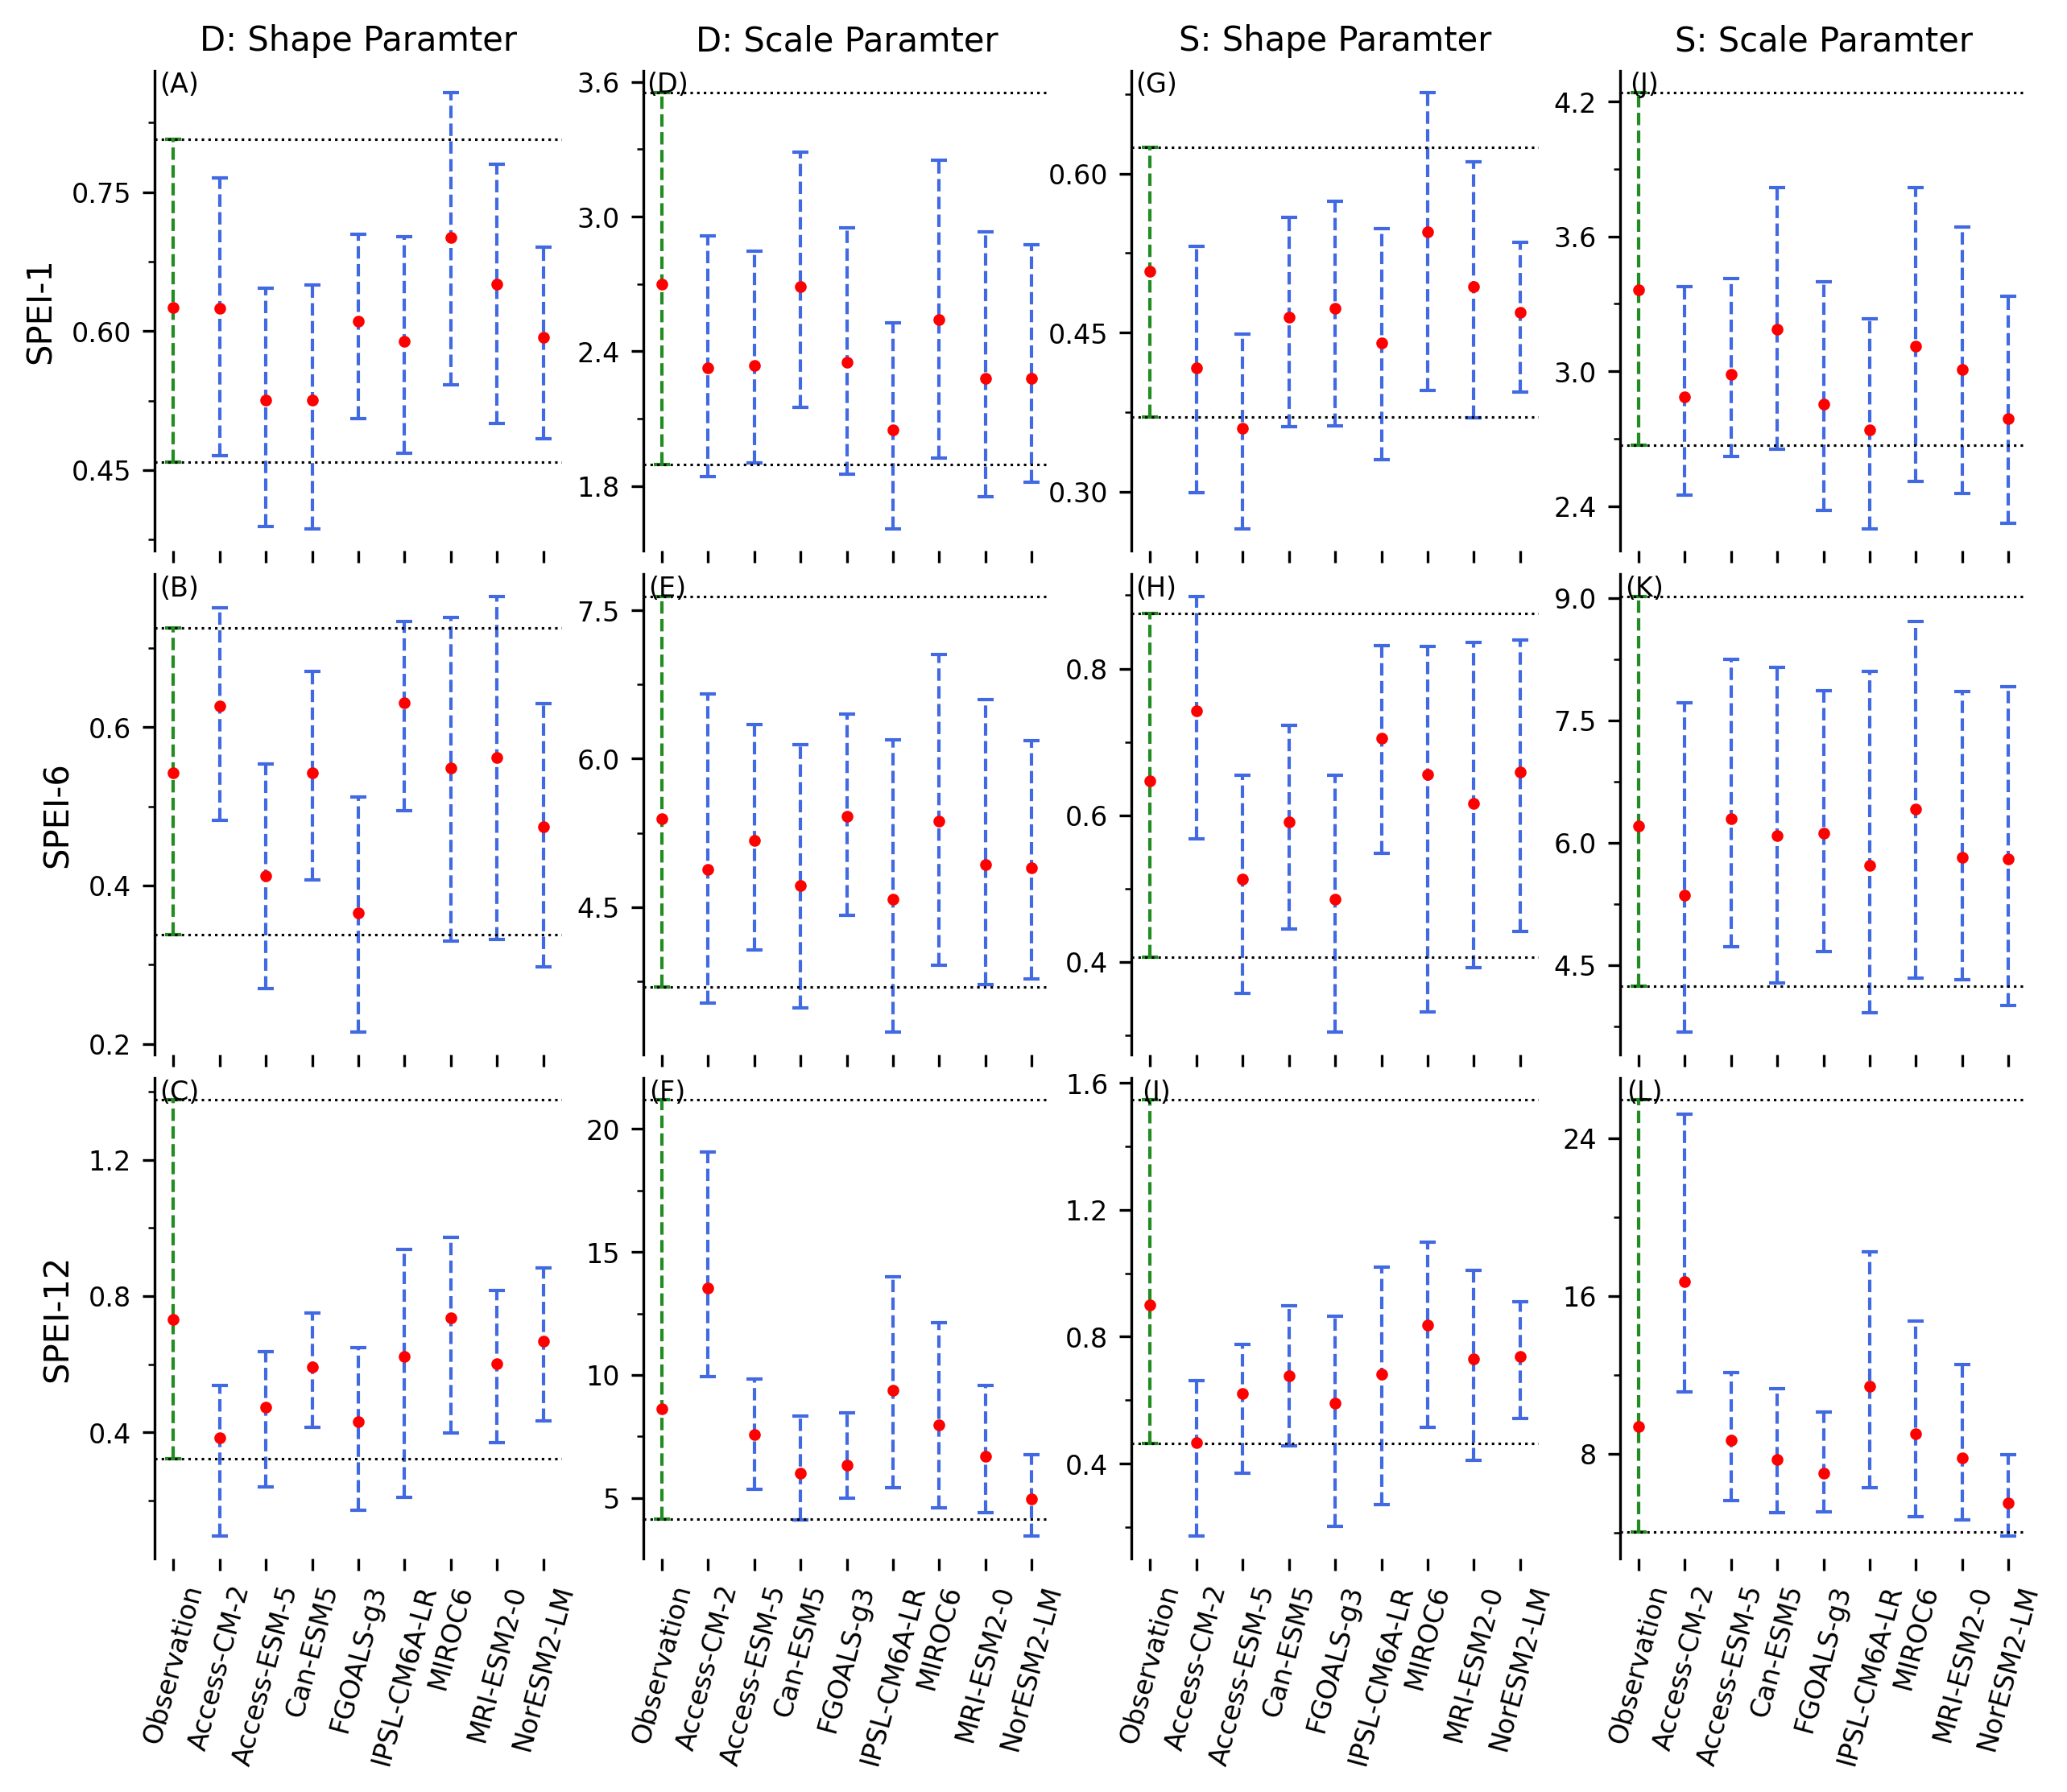

In [33]:
#Plot the data
names_plots=["D: Shape Paramter","D: Scale Paramter","S: Shape Paramter","S: Scale Paramter"]

names_models = np.array(["Observation","Access-CM-2","Access-ESM-5","Can-ESM5","FGOALS-g3","IPSL-CM6A-LR","MIROC6","MRI-ESM2-0","NorESM2-LM"])
names_P1 = ["Param1_obs","P1_AccessCm2","P1_AccessEsm15","P1_CanEsm5","P1_FgoalsG3","P1_IpslCm6aLr","P1_Miroc6","P1_MriEsm20","P1_NorEsm2Lm"]
names_P2 = ["Param2_obs","P2_AccessCm2","P2_AccessEsm15","P2_CanEsm5","P2_FgoalsG3","P2_IpslCm6aLr","P2_Miroc6","P2_MriEsm20","P2_NorEsm2Lm"]

param_res_D = [M1_param_res_D,M6_param_res_D,M12_param_res_D]
param_res_S = [M1_param_res_S,M6_param_res_S,M12_param_res_S]
fig, ax = plt.subplots(ncols = 4, nrows = 3,figsize=(10,8),dpi = 300,sharex="col")
fig.subplots_adjust(hspace=0.05)
#fig.subplots_adjust(wspace=0.05)

for r in np.arange(0,3,1):
    for i in np.arange(0,9,1):
        if i == 0:
            mean = float(param_res_D[r][names_P1[i]][0])
            lower = float(param_res_D[r][names_P1[i]][1])
            upper = float(param_res_D[r][names_P1[i]][2])
            test=ax[r][0].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', ecolor='forestgreen', 
                         elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
        else:
            mean = float(param_res_D[r][names_P1[i]][0])
            lower = float(param_res_D[r][names_P1[i]][1])
            upper = float(param_res_D[r][names_P1[i]][2])
            test=ax[r][0].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', 
                                ecolor='royalblue', elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
    ax[r][0].axhline(y=float(param_res_D[r][names_P1[0]][1]), color='black', linestyle='dotted',lw=0.75)
    ax[r][0].axhline(y=float(param_res_D[r][names_P1[0]][2]), color='black', linestyle='dotted',lw=0.75)

    for i in np.arange(0,9,1):
        if i == 0:
            mean = float(param_res_D[r][names_P2[i]][0])
            lower = float(param_res_D[r][names_P2[i]][1])
            upper = float(param_res_D[r][names_P2[i]][2])
            test=ax[r][1].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', ecolor='forestgreen', 
                         elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
        else:
            mean = float(param_res_D[r][names_P2[i]][0])
            lower = float(param_res_D[r][names_P2[i]][1])
            upper = float(param_res_D[r][names_P2[i]][2])
            test=ax[r][1].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', ecolor='royalblue', 
                         elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
    ax[r][1].axhline(y=float(param_res_D[r][names_P2[0]][1]), color='black', linestyle='dotted',lw=0.75)
    ax[r][1].axhline(y=float(param_res_D[r][names_P2[0]][2]), color='black', linestyle='dotted',lw=0.75)

    for i in np.arange(0,9,1):
        if i == 0:
            mean = float(param_res_S[r][names_P1[i]][0])
            lower = float(param_res_S[r][names_P1[i]][1])
            upper = float(param_res_S[r][names_P1[i]][2])
            test=ax[r][2].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', ecolor='forestgreen', 
                         elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
        else:
            mean = float(param_res_S[r][names_P1[i]][0])
            lower = float(param_res_S[r][names_P1[i]][1])
            upper = float(param_res_S[r][names_P1[i]][2])
            test=ax[r][2].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', ecolor='royalblue', 
                         elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
    ax[r][2].axhline(y=float(param_res_S[r][names_P1[0]][1]), color='black', linestyle='dotted',lw=0.75)
    ax[r][2].axhline(y=float(param_res_S[r][names_P1[0]][2]), color='black', linestyle='dotted',lw=0.75)

    for i in np.arange(0,9,1):
        if i == 0:
            mean = float(param_res_S[r][names_P2[i]][0])
            lower = float(param_res_S[r][names_P2[i]][1])
            upper = float(param_res_S[r][names_P2[i]][2])
            test=ax[r][3].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', ecolor='forestgreen', 
                         elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
        else:
            mean = float(param_res_S[r][names_P2[i]][0])
            lower = float(param_res_S[r][names_P2[i]][1])
            upper = float(param_res_S[r][names_P2[i]][2])
            test=ax[r][3].errorbar(i,mean,yerr=[[mean-lower],[upper-mean]],fmt='o', markersize=2.5, color='red', ecolor='royalblue', 
                         elinewidth=1, capsize=2.5, capthick=1, linestyle='dashed')
            test[-1][0].set_linestyle('--')
    ax[r][3].axhline(y=float(param_res_S[r][names_P2[0]][1]), color='black', linestyle='dotted',lw=0.75)
    ax[r][3].axhline(y=float(param_res_S[r][names_P2[0]][2]), color='black', linestyle='dotted',lw=0.75)

    for n in np.arange(0,4,1):
        #ax[r][n].yaxis.set_major_locator(MultipleLocator(.5))# defines setting of the small ticks
        ax[r][n].yaxis.set_minor_locator(AutoMinorLocator(n=2))
        ax[r][n].yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax[r][n].tick_params(axis='y', which='major', labelsize='8')
        #ax[r][n].set_title(names_plots[n], loc = "center",fontsize=10)
        ax[r][n].spines[['top', 'right', 'bottom']].set_visible(False)
        names_x = np.arange(0,9,1)
        ax[r][n].set_xticks(names_x, names_models, rotation=75,fontsize='8')
for c in np.arange(0,4,1):   
    ax[0][c].set_title(names_plots[c], loc = "center",fontsize=10)
ax[0][0].set_ylabel(r'SPEI-1',fontsize='10')
ax[1][0].set_ylabel(r'SPEI-6',fontsize='10')
ax[2][0].set_ylabel(r'SPEI-12',fontsize='10')

# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)','(E)', '(F)', '(G)', '(H)','(I)', '(J)', '(K)', '(L)']

# Get the total number of rows and columns
nrows, ncols = ax.shape
# Iterate over each subplot in column-major order
index_label = 0
for i in range(ncols):
    for j in range(nrows):
        axes = ax[j, i]
        axes.annotate(labels[index_label], xy=(0.06, 0.97), xycoords='axes fraction',
                  fontsize=8, ha='center', va='center')
        index_label += 1

# Display the plot
plt.show()
#plt.savefig('images/eval_dist_10.png')